## Setup model

### Select model

In [1]:
import numpy as np
import pandas as pd
import h5py

# model_name = 'neuronal_model_496930324'
# model_name = 'neuronal_model_497229089'
model_name = 'neuronal_model_491766131'

dynamics_params = model_name + '.json'
morphology = model_name+'_rotate.swc'

### Build bmtk network

In [2]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('Cell')
net.add_nodes(cell_name = 'Cell',
              potental = 'exc',
              model_type = 'biophysical',
              model_template = 'ctdb:Biophys1.hoc',
              model_processing = 'aibs_allactive',
              dynamics_params = dynamics_params, #from allen database
              morphology = morphology) # rotated swc file

In [3]:
net.build()
net.save_nodes(output_dir='network')

### Build

In [4]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='sim_details',
                 network_dir='network',
                 tstop=300.0, dt=0.025,
                 v_init=-90.0,             # use e_pas in dynamics_params file
                 report_vars=['v'],
#                  spikes_inputs=[('Source','sim_details/synaptic_input.csv')],
                 config_file = 'config.json',
                 current_clamp={       # Creates a step current from 500.0 ms to 1500.0 ms
                    'amp': -0.010,
                    'delay': 100.0,
                    'duration': 150.0
                },
                 include_examples=True,    # Copies components files
                 compile_mechanisms=True   # Will try to compile NEURON mechanisms
                )

ERROR:bmtk.utils.sim_setup:  Was unable to compile mechanism in D:\reserch_temp\detailed-single-cell\sim_details\components\mechanisms


### Run bmtk

In [5]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('sim_details/config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)

2022-07-17 16:43:11,173 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2022-07-17 16:43:11,445 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-07-17 16:43:11,806 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


#### Record axial current

In [6]:
from utils.currents.somaaxialcurrent import Soma_Axial_Current

axial_current = Soma_Axial_Current(sim.net.get_cell_gid(0).get_section(0),record_t=True)

In [7]:
sim.run()

2022-07-17 16:43:11,973 [INFO] Running simulation for 300.000 ms with the time step 0.025 ms


INFO:NEURONIOUtils:Running simulation for 300.000 ms with the time step 0.025 ms


2022-07-17 16:43:11,975 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-07-17 16:43:11,977 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-07-17 16:43:20,668 [INFO]     step:5000 t_sim:125.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:125.00 ms


2022-07-17 16:43:29,672 [INFO]     step:10000 t_sim:250.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:250.00 ms


2022-07-17 16:43:33,309 [INFO]     step:12000 t_sim:300.00 ms


INFO:NEURONIOUtils:    step:12000 t_sim:300.00 ms


2022-07-17 16:43:33,326 [INFO] Simulation completed in 21.35 seconds 


INFO:NEURONIOUtils:Simulation completed in 21.35 seconds 


### Check Results

In [8]:
import h5py
import numpy as np
import pandas as pd
import os

outpath = 'sim_details/output/'

#### Check membrane voltage

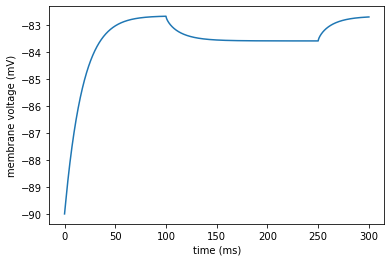

In [9]:
filename = 'v_report.h5'
v_file = outpath + filename
v_f = h5py.File(v_file,'r')

V = v_f['report/Cell/data'][()]
t = np.arange(*v_f['report/Cell/mapping/time']) # array of time

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(t,V)
plt.xlabel('time (ms)')
plt.ylabel('membrane voltage (mV)')
plt.show()

#### Calculate passive properties

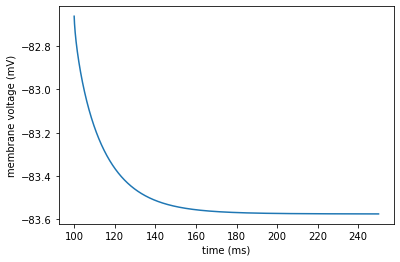

In [10]:
from utils.metrics.measure_passive_properties import measure_passive_properties
%matplotlib inline

plt.figure()
Vrest, Rin, Tau = measure_passive_properties(V,t,sim._iclamps[0]._stim,ax=plt.gca())

In [11]:
Vrest, Rin, Tau

(-82.66099675797402, 91.51170988756974, 12.700000000000003)

#### Check axial currents

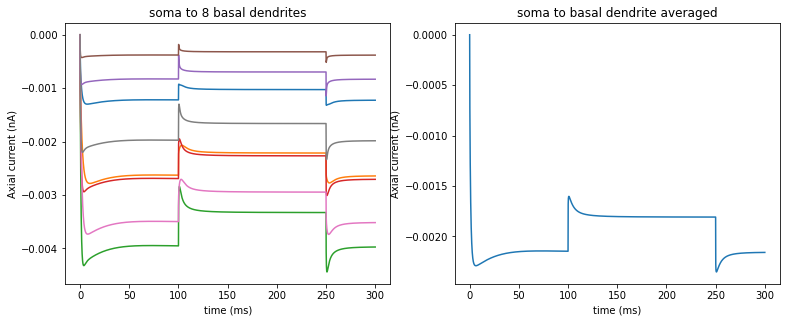

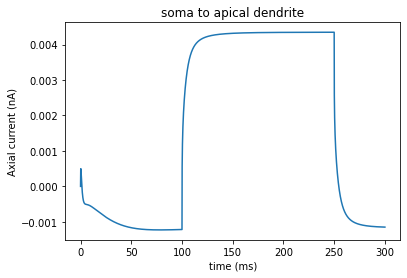

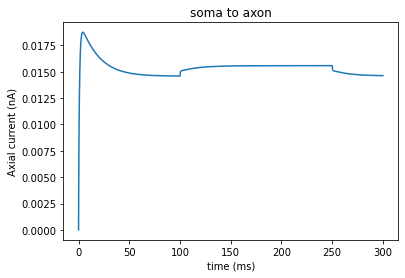

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

t = axial_current.t()
ac = axial_current.get_current()

ac_dend = ac['dend'].T
plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
plt.plot(t,ac_dend)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to {} basal dendrites'.format(ac_dend.shape[1]))
plt.subplot(122)
plt.plot(t,np.mean(ac_dend,axis=1))
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to basal dendrite averaged')
plt.show()

ac_apic = ac['apic'].T
plt.figure()
plt.plot(t,ac_apic)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to apical dendrite')
plt.show()

ac_axon = ac['axon'].T
plt.figure()
plt.plot(t,ac_axon)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to axon')
plt.show()